In [1]:
import jax
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp
import distrax
from advi_jax import ADVI
from IPython.display import clear_output

## Defining ADVI types

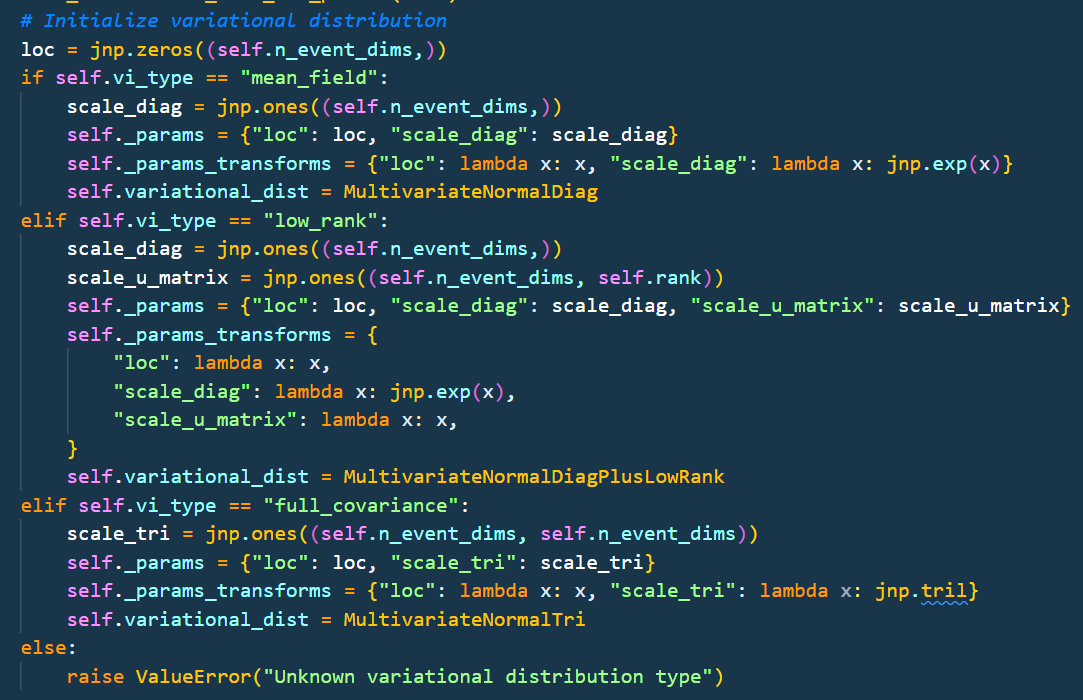

# Beta-Binomial

In [5]:
prior = {'p_of_heads': tfp.distributions.Beta(2.0, 2.0)}
prior_transforms = {'p_of_heads': distrax.Sigmoid()}

def log_likelihood(params, data):
    dist = distrax.Bernoulli(probs=params['p_of_heads'])
    return jax.vmap(dist.log_prob)(data).sum()

model = ADVI(prior, prior_transforms, log_likelihood, vi_type="mean_field", rank=None)

# Learning Mean of Bivariate Normal

## Generate data

In [10]:
key = jax.random.PRNGKey(0)
N = 1000

data = jax.random.normal(key, shape=(N, 2))
data.shape

(1000, 2)

## Model specification

In [8]:
# prior
loc = jnp.zeros((2,))
cov = jnp.eye(2)
prior = {"mean": distrax.MultivariateNormalFullCovariance(loc=loc, covariance_matrix=cov)}
prior_transforms = {"mean": distrax.Lambda(lambda x: x)}

# likelihood
def log_likelihood(params, data):
    fixed_cov = jnp.eye(2)
    dist = distrax.MultivariateNormalFullCovariance(loc=params['mean'], covariance_matrix=fixed_cov)
    return jax.vmap(dist.log_prob)(data).sum()

In [9]:
model = ADVI(prior, prior_transforms, log_likelihood, vi_type='mean_field')

## Optimization

In [ ]:
n_samples = 10
for epoch in range(epochs):
    key = jax.random.PRNGKey(epoch+1234)
    # key = jax.random.PRNGKey(1234)  # Deterministic ADVI
    keys = jax.random.split(key, n_samples)
    model.objective_fun(model._params, keys, data)

In [5]:
model.sample_posterior(key, sample_shape=(1,))

## SVI (NumPyro)

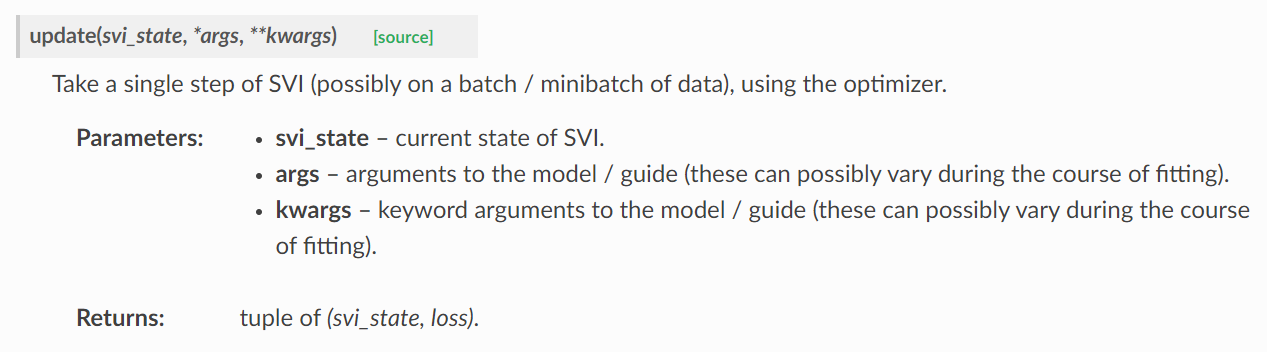

## SVI

In [ ]:
batch_size = 20
def log_likelihood(params, data, batch_size=None, seed=None):
    fixed_cov = jnp.eye(2)
    dist = distrax.MultivariateNormalFullCovariance(loc=params['mean'], covariance_matrix=fixed_cov)
    batch = jax.random.shuffle(key, data)[:batch_size]
    return jax.vmap(dist.log_prob)(batch).sum() * (len(data)/batch_size)

key = jax.random.PRNGKey(epoch+1234)
keys = jax.random.split(key, n_samples)

model.objective_fun(model._params, keys, data, batch_size, seed)

# Learn Mean and Cov of Bivariate Normal

In [ ]:
# prior
loc = jnp.zeros((2,))
cov = jnp.eye(2)  # Or any PSD matrix
prior = {"mean": distrax.MultivariateNormalFullCovariance(loc=loc, covariance_matrix=cov), 
       "corr": tfp.distributions.CholeskyLKJ(dimension=2, concentration=0.1)
#          OR
#        "corr": tfp.distributions.LKJ(dimension=2, concentration=0.1)
         "sigma": distrax.MultivariateNormalFullCovariance(loc=loc, covariance_matrix=cov)
        }
prior_transforms = {"mean": distrax.Lambda(lambda x: x), 
                    "corr": distrax.Lambda(lambda x: jax.nn.tanh(x)),
                    "simga": distrax.Lambda(lambda x: jnp.exp(x))}

# likelihood
def log_likelihood(params, data):
    loc = params["mean"]
    L_corr = params["corr"]
    sigma = params["sigma"]
    
    L = jnp.diag(sigma)@L_corr
    cov = L@L.T
    dist = distrax.MultivariateNormalTri(loc, covariance_matrix=cov)
    return jax.vmap(dist.log_prob)(data).sum()

# Linear Regression

In [12]:
tfp.distributions.LKJ(dimension=3, concentration=0.1).sample(seed=jax.random.PRNGKey(1))
tfp.experimental.bijectors.

/home/patel_zeel/miniconda3/envs/pyprobml/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:2692: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "zeros")


DeviceArray([[ 1.        , -0.74805605, -0.66760427],
             [-0.74805605,  1.        ,  0.01462496],
             [-0.66760427,  0.01462496,  1.        ]], dtype=float32)

In [ ]:
prior = {"weights": distrax.MultivariateNormalFullCovariance(mean, cov), 
         "noise_var": distrax.Gamma(concentration=0.1)
        }
prior_transforms = {"weights": distrax.Lambda(lambda x:x)
                   "noise_var": distrax.Lambda(lambda x: jnp.exp(x))}

def log_likelihood(params, data):
    x, y = data
    return jax.vmap(lambda x, y: distrax.Normal(x*params['weights'], params['noise_var']).log_prob(y), in_axes=(0, 0))(x, y)